<a href="https://colab.research.google.com/github/jose-marquez89/DS-Unit-2-Kaggle-Challenge/blob/master/module1-decision-trees/LS_DS_221_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [x] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [x] Do train/validate/test split with the Tanzania Waterpumps data.
- [x] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [0]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [353]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [354]:
# Performs a train/validate split on the training data
train, val = train_test_split(train, stratify=train['status_group'], 
                              test_size=0.2, random_state=42)
train.shape, val.shape

((47520, 41), (11880, 41))

In [0]:
# Pandas Profiling can be very slow with medium & large datasets.
# These parameters will make it faster.
# https://github.com/pandas-profiling/pandas-profiling/issues/222

import pandas_profiling

profile_report = train.profile_report(
    correlations={
        'pearson': False,
        'spearman': False,
        'kendall': False,
        'phi_k': False,
        'cramers': False,
        'recoded': False,
    },
    plot={'histogram': {'bayesian_blocks_bins': False}},
)

profile_report

In [0]:
import numpy as np
def wrangle(X):
  '''Apply wrangling to a dataframe'''

  # Copy
  X = X.copy()
  # Convert near zero values to zero
  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  X['date_recorded'] = pd.to_datetime(X['date_recorded'])
  X['month_recorded'] = X['date_recorded'].dt.month
  X['year_recorded'] = X['date_recorded'].dt.year


  # Replace zeros that should be null values with np.nan
  cols_with_zeros = ['longitude', 'latitude', 'population', 'construction_year']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)

  # Drop Duplicate columns
  X = X.drop(columns='quantity_group')

  # Return wrangled dataframe
  return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

### Begin with baselines
Based on the baseline, if we guessed that each unit was functional, we would be correct ~54% of the time

In [48]:
train['status_group'].value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

### Feature selection
Here, selectKBest will be used along with a decision tree classifier to select the ideal columns

In [356]:
# Target column
target = 'status_group'

# Drop id and target from dataframe
train_features = train.drop(columns=[target, 'id'])

# List of numeric features
numeric_features = (train_features
                    .select_dtypes(include='number')
                    .columns
                    .tolist()
                   )

# Series with cardinality of object columns
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine lists
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'month_recorded', 'year_recorded', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [0]:
# Arrange data
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [0]:
# Encode, impute, select ideal features based on accuracy score
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline

def bestTreeK(X_trn, X_tst, y_trn, y_tst):
  '''
  Encodes train and test, imputes missing values, fits
  a decision tree classifier and returns best k along with 
  accuracy score, using a pipeline'''

  train_score = None
  test_score = None
  best_k = None
  
  encoder = ce.OneHotEncoder(use_cat_names=True)
  imputer = SimpleImputer()
  model = DecisionTreeClassifier(min_samples_leaf=1, 
                                   max_depth=16, 
                                   random_state=42)
  
  # Encode and impute train and test dataframes
  Xtr_enc = encoder.fit_transform(X_trn)
  Xtr_imp = imputer.fit_transform(Xtr_enc)
  Xts_enc = encoder.transform(X_tst)
  Xts_imp = imputer.transform(Xts_enc)
  
  # Run decision tree on X_train and iteravily arrive at parameter choice
  for k in range(1,Xts_imp.shape[1]+1):  
    
    selector = SelectKBest(score_func=f_classif, k=k)
    Xtr_sel = selector.fit_transform(Xtr_imp, y_trn)
    Xts_sel = selector.transform(Xts_imp)


    
    # Get model score for train
    model.fit(Xtr_sel, y_trn)
    trn_score = model.score(Xtr_sel, y_trn)
    
    # Get model score for test
    tst_score = model.score(Xts_sel, y_tst)

    if k == 1:
      train_score = trn_score
      test_score = tst_score
      best_k = k
    else:
      if tst_score > test_score:
        train_score = trn_score
        test_score = tst_score
        best_k = k

  output = f"Best Test Accuracy is {test_score} "\
           f"Best k: {k}\nTrain Accuracy with this model: {train_score}"
  return output

In [0]:
print(bestTreeK(X_train, X_val, y_train, y_val))

In [364]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, SelectFwe
from sklearn.pipeline import make_pipeline

# Use pipeline to fit multiple sklearn tools

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    
    SimpleImputer(strategy='most_frequent'),
    DecisionTreeClassifier(min_samples_leaf=1,
                           max_depth=16,
                           random_state=42)
)
pipeline.fit(X_train, y_train)
print("Tr. Acc:", pipeline.score(X_train, y_train))
print("Ts. Acc:", pipeline.score(X_val, y_val))

Tr. Acc: 0.8505260942760943
Ts. Acc: 0.7741582491582492


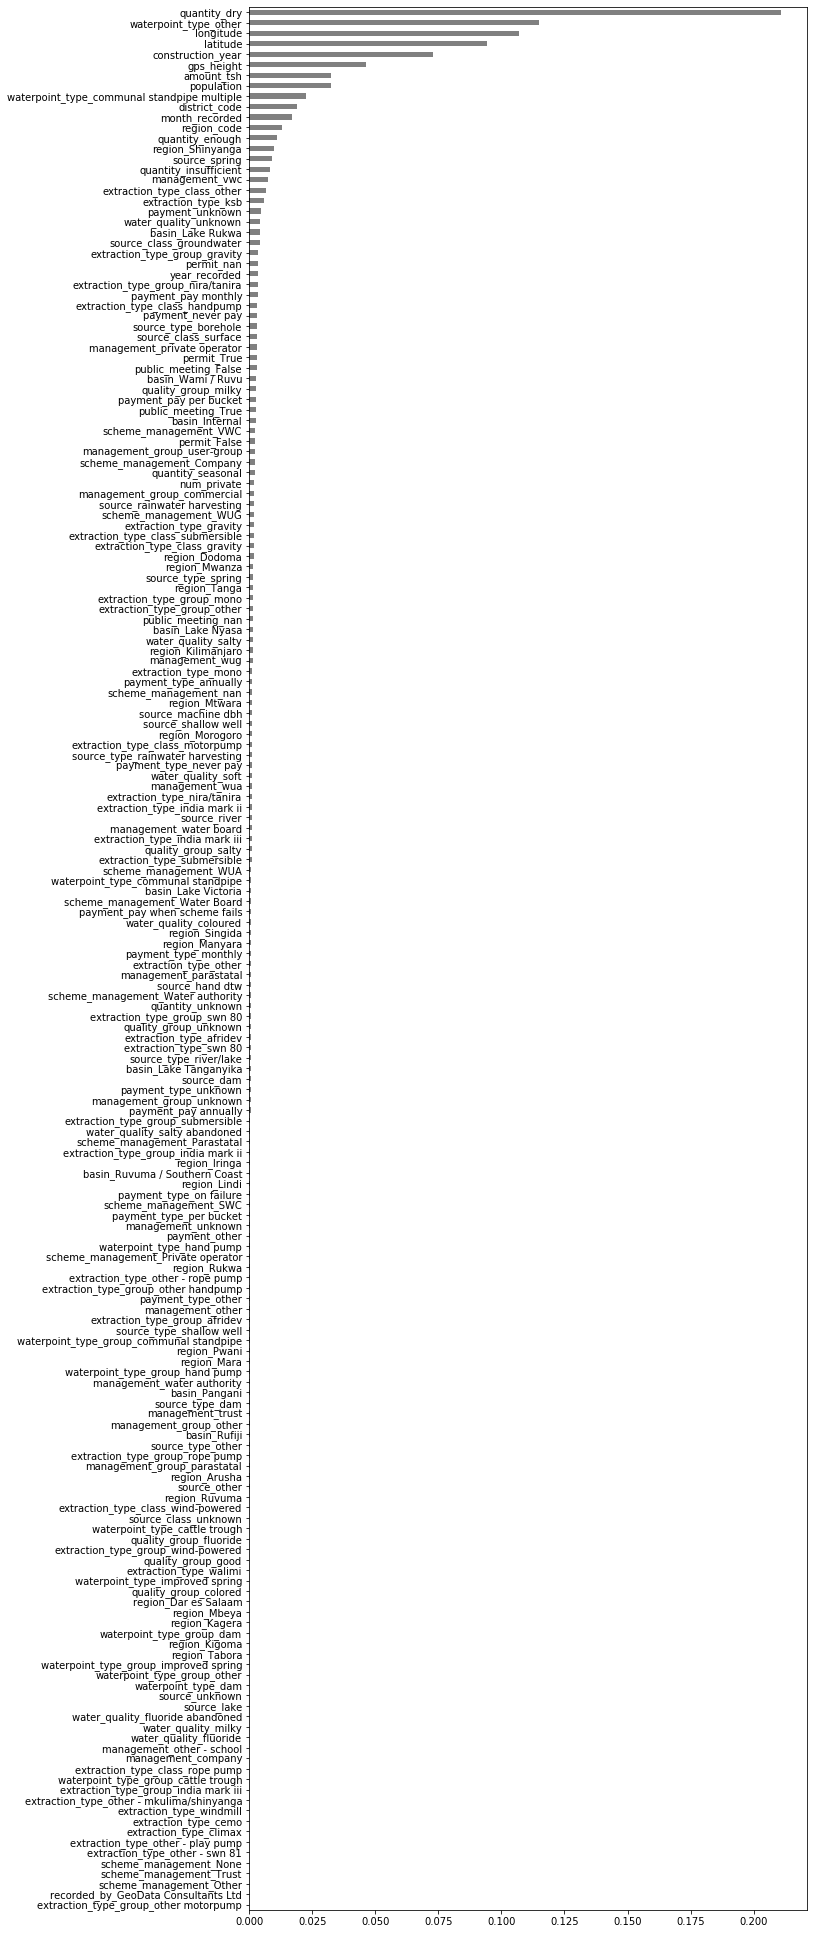

In [363]:
# Plot the feature importances
import matplotlib.pyplot as plt
model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,35))
importances.sort_values().plot.barh(color='grey');

In [0]:
# Submission csv
y_pred = pipeline.predict(X_test)

submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('jose-marquez-ds11-wp.csv', index=False)

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,functional
4,49871,functional
...,...,...
14353,39307,functional
14354,18990,functional
14355,28749,functional
14356,33492,functional
